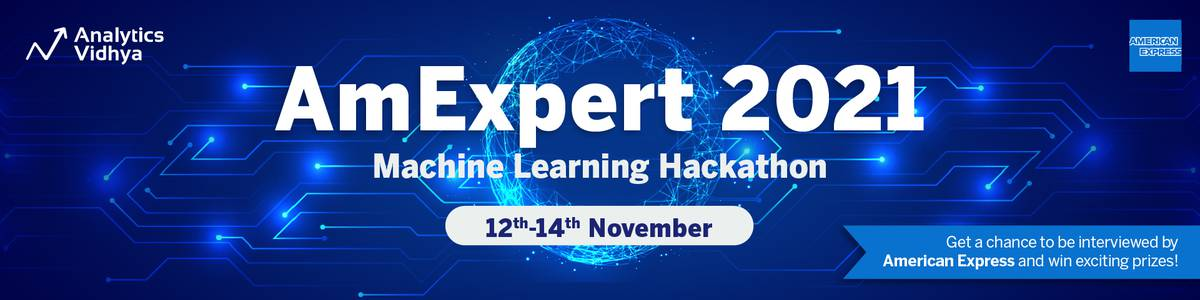

# config & mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
epoch = 20

Mounted at /content/drive


# imports

In [16]:
#basic imports
import pandas as pd
import numpy as np
import gc
import re

#for prepcorssings
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#for the deep learning model
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, Add, GRU
from IPython.display import clear_output
#supporting files
from preprocessdata import *

# read and presprocess

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/AMEX_DRIVE/amex_data/train_go05W65.csv")
test=pd.read_csv("/content/drive/MyDrive/AMEX_DRIVE/amex_data/test_VkM91FT.csv")
sub=pd.read_csv("/content/drive/MyDrive/AMEX_DRIVE/amex_data/sample_submission_kF044ur.csv")
test.drop('Customer_ID',axis=1, inplace=True)
train.drop('Customer_ID',axis=1, inplace=True)

In [ ]:
processB1(train['Product_Holding_B1'],'train',train,test)
processB2(train['Product_Holding_B2'],train)
processB1(test['Product_Holding_B1'],'test',train,test)
clear_output()

In [ ]:
train.drop(['Product_Holding_B1','Product_Holding_B2','P21_T','P19_T'],axis=1, inplace=True)
test.drop(['Product_Holding_B1'],axis=1, inplace=True)
train=pd.get_dummies(data=train, columns=['Gender', 'City_Category','Customer_Category'],drop_first=True)
test=pd.get_dummies(data=test, columns=['Gender', 'City_Category','Customer_Category'],drop_first=True)
l=['P00_T']
for i in range(1,22):
    if i!=19 and i!=21:
        l.append('P'+str(i)+'_T')
X = train.drop(columns =l,axis=1)
y = train[l]
rs = RobustScaler()
rs.fit(X)
X = rs.transform(X)
test = rs.transform(test)
X = X.astype(np.float32)
test = test.astype(np.float32)
gc.collect()
fold = 5
train2 = X.reshape(-1, 1, X.shape[-1])
test = test.reshape(-1, 1, test.shape[-1])

# making the model.............

In [ ]:
def initial(input): 
  l1=  Bidirectional(LSTM(units=1024, return_sequences=True))(input)
  l2 = Bidirectional(LSTM(units=768, return_sequences=True))(l1)
  l3 = Bidirectional(LSTM(units=512, return_sequences=True))(l2)
  l4 = Bidirectional(LSTM(units=384, return_sequences=True))(l3)
  l5 = Bidirectional(LSTM(units=256, return_sequences=True))(l4)
  l6 = Bidirectional(LSTM(units=192, return_sequences=True))(l5)
  l7 = Bidirectional(LSTM(units=128, return_sequences=True))(l6)
  l8 = Bidirectional(LSTM(units=96, return_sequences=True))(l7)
  l9 = Bidirectional(LSTM(units=64, return_sequences=True))(l8)
  print(50*'-')
  return l2,l3,l4,l5,l6,l7,l8,l9

def biGRU(x2,x3,x4,x5,x6,x7,x8,x9,activation='selu'):
  z2 = Bidirectional(GRU(units=512, return_sequences=True))(x2)
  z31 = Multiply()([x3, z2])
  z31 = BatchNormalization()(z31)
  z3 = Bidirectional(GRU(units=384, return_sequences=True))(z31)
  z41 = Multiply()([x4, z3])
  z41 = BatchNormalization()(z41)
  z4 = Bidirectional(GRU(units=256, return_sequences=True))(z41)
  z51 = Multiply()([x5, z4])
  z51 = BatchNormalization()(z51)
  z5 = Bidirectional(GRU(units=192, return_sequences=True))(z51)
  z61 = Multiply()([x6, z5])
  z61 = BatchNormalization()(z61)
  z6 = Bidirectional(GRU(units=128, return_sequences=True))(z61)
  z71 = Multiply()([x7, z6])
  z71 = BatchNormalization()(z71)
  z7 = Bidirectional(GRU(units=96, return_sequences=True))(z71)
  z81 = Multiply()([x8, z7])
  z81 = BatchNormalization()(z81)
  z8 = Bidirectional(GRU(units=64, return_sequences=True))(z81)
  x = Concatenate(axis=2)([x9, z2, z3, z4, z5 ,z6,z7,z8])
  x = Dense(units=128, activation=activation)(x)
  print(activation,'have been used here!!!')
  x_output = Dense(units=1,activation='sigmoid')(x)
  print(50*'-')
  return x_output

def main_model():  
  x_input = keras.Input(shape=(train2.shape[-2:]))
  x2,x3,x4,x5,x6,x7,x8,x9 = initial(x_input)
  x_output = biGRU(x2,x3,x4,x5,x6,x7,x8,x9)
  model = keras.Model(inputs=x_input, outputs=x_output)
  print('MODEL initialized')
  model.compile(optimizer='Adam',
                loss="binary_crossentropy")
  return model 

# observe the model

In [20]:
main_model().summary

--------------------------------------------------
selu have been used here!!!
--------------------------------------------------
MODEL initialized


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f91743b1710>>

--------------------------------------------------
selu have been used here!!!
--------------------------------------------------
MODEL initialized


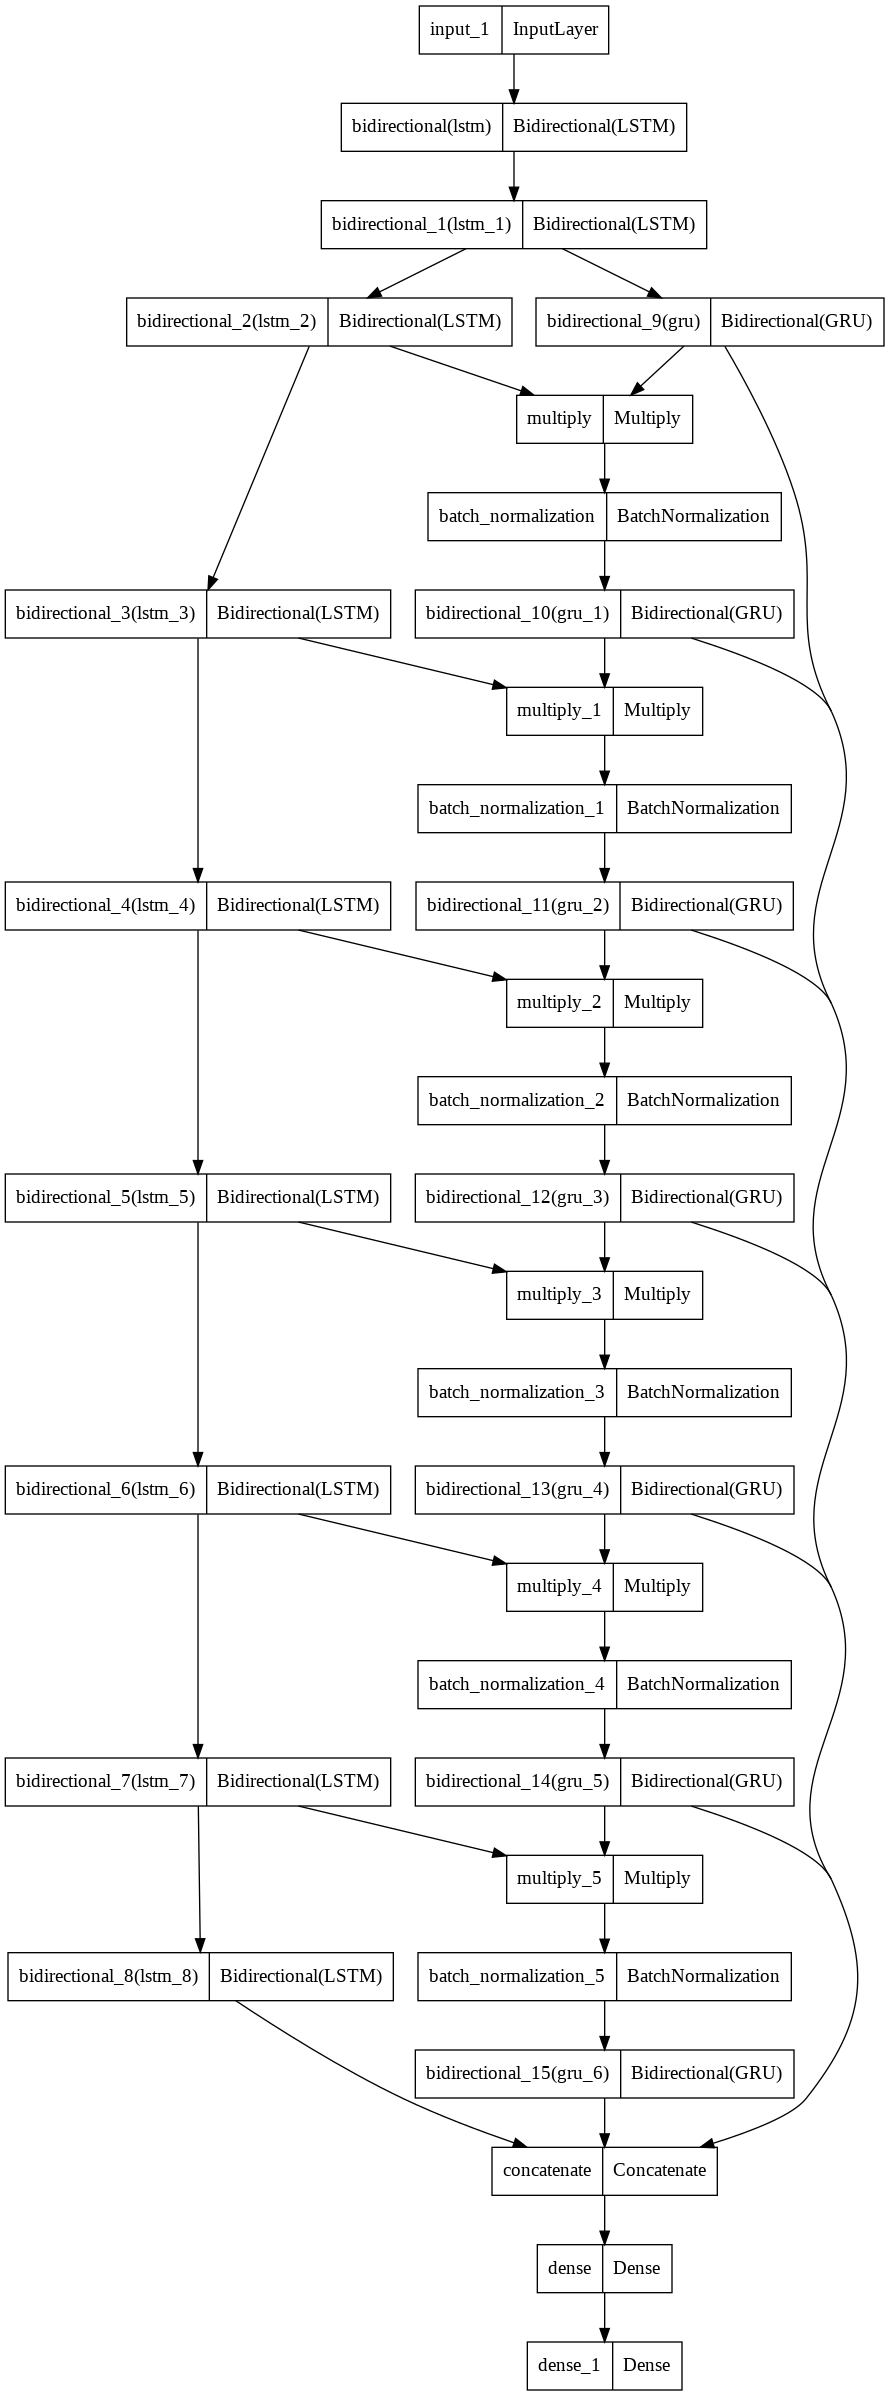

In [ ]:
plot_model(main_model())

# training

In [8]:
full_model= main_model()
es = EarlyStopping(patience = 5,
                       verbose = 1,
                       restore_best_weights = True)
history = full_model.fit(
    x=train2,
    y=y['P00_T'],
    batch_size = 64,
    callbacks = [es],
    validation_split = 0.1,
    shuffle=True,
    epochs=epoch)
pred1=full_model.predict(test)
LIST=[]
for i in range(1,19):
    full_model= main_model()
    es = EarlyStopping(patience = 5,
                           verbose = 1,
                           restore_best_weights = True)
    history = full_model.fit(
        x=train2,
        y=y['P'+str(i)+'_T'],
        batch_size = 64,
        callbacks = [es],
        validation_split = 0.1,
        shuffle=True,
        epochs=epoch)
    LIST.append(full_model.predict(test))
    
full_model= main_model()
es = EarlyStopping(patience = 5,
                       verbose = 1,
                       restore_best_weights = True)
history = full_model.fit(
    x=train2,
    y=y['P20_T'],
    batch_size = 64,
    callbacks = [es],
    validation_split = 0.1,
    shuffle=True,
    epochs=epoch)
pred20=full_model.predict(test)

--------------------------------------------------
selu have been used here!!!
--------------------------------------------------
MODEL initialized
Epoch 1/20
531/531 [==============================] - 80s 65ms/step - loss: 0.2427 - val_loss: 0.2185
Epoch 2/20
531/531 [==============================] - 25s 46ms/step - loss: 0.2250 - val_loss: 0.2148
Epoch 3/20
531/531 [==============================] - 25s 46ms/step - loss: 0.2203 - val_loss: 0.2133
Epoch 4/20
531/531 [==============================] - 24s 46ms/step - loss: 0.2187 - val_loss: 0.2078
Epoch 5/20
531/531 [==============================] - 25s 46ms/step - loss: 0.2138 - val_loss: 0.2045
Epoch 6/20
531/531 [==============================] - 25s 47ms/step - loss: 0.2093 - val_loss: 0.2056
Epoch 7/20
531/531 [==============================] - 24s 46ms/step - loss: 0.2076 - val_loss: 0.2076
Epoch 8/20
531/531 [==============================] - 24s 46ms/step - loss: 0.2060 - val_loss: 0.2034
Epoch 9/20
531/531 [================

# SUBMIT

In [18]:
submission(sub,0.15,LIST,pred1,pred20)
submission(sub,0.20,LIST,pred1,pred20)
submission(sub,0.25,LIST,pred1,pred20)
submission(sub,0.30,LIST,pred1,pred20)
submission(sub,0.35,LIST,pred1,pred20)

      Customer_ID Product_Holding_B2
0        CC372708       ['P8','P10']
1        CC216072        ['P1','P8']
2        CC387629      ['P13','P16']
3        CC389228       ['P8','P10']
4        CC394445            ['P00']
...           ...                ...
20322    CC303542       ['P00','P8']
20323    CC266713       ['P8','P12']
20324    CC393639  ['P00','P8','P9']
20325    CC285013   ['P1','P3','P6']
20326    CC274657   ['P3','P6','P7']

[20327 rows x 2 columns] 0.15
      Customer_ID Product_Holding_B2
0        CC372708       ['P8','P10']
1        CC216072        ['P1','P8']
2        CC387629      ['P13','P16']
3        CC389228             ['P8']
4        CC394445            ['P00']
...           ...                ...
20322    CC303542       ['P00','P8']
20323    CC266713             ['P8']
20324    CC393639       ['P00','P8']
20325    CC285013   ['P1','P3','P6']
20326    CC274657   ['P3','P6','P7']

[20327 rows x 2 columns] 0.2
      Customer_ID Product_Holding_B2
0        CC372